<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# проверка хронологического расположения дат и времени
data = data.sort_index(ascending = True)
print(data.index.is_monotonic)

True


<AxesSubplot:xlabel='datetime'>

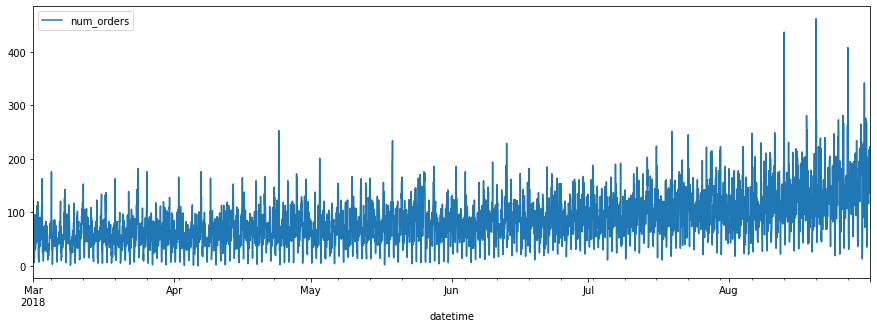

In [6]:
# ресемплирование по одному часу
data = data.resample('1H').sum()
data.plot()

### Вывод
Загружены данные о заказах такси в аэропортах. Всего 26496 записей. Пропусков нет. Интервал - 10 минут. Данные расположены в хронологическом порядке.

## Анализ

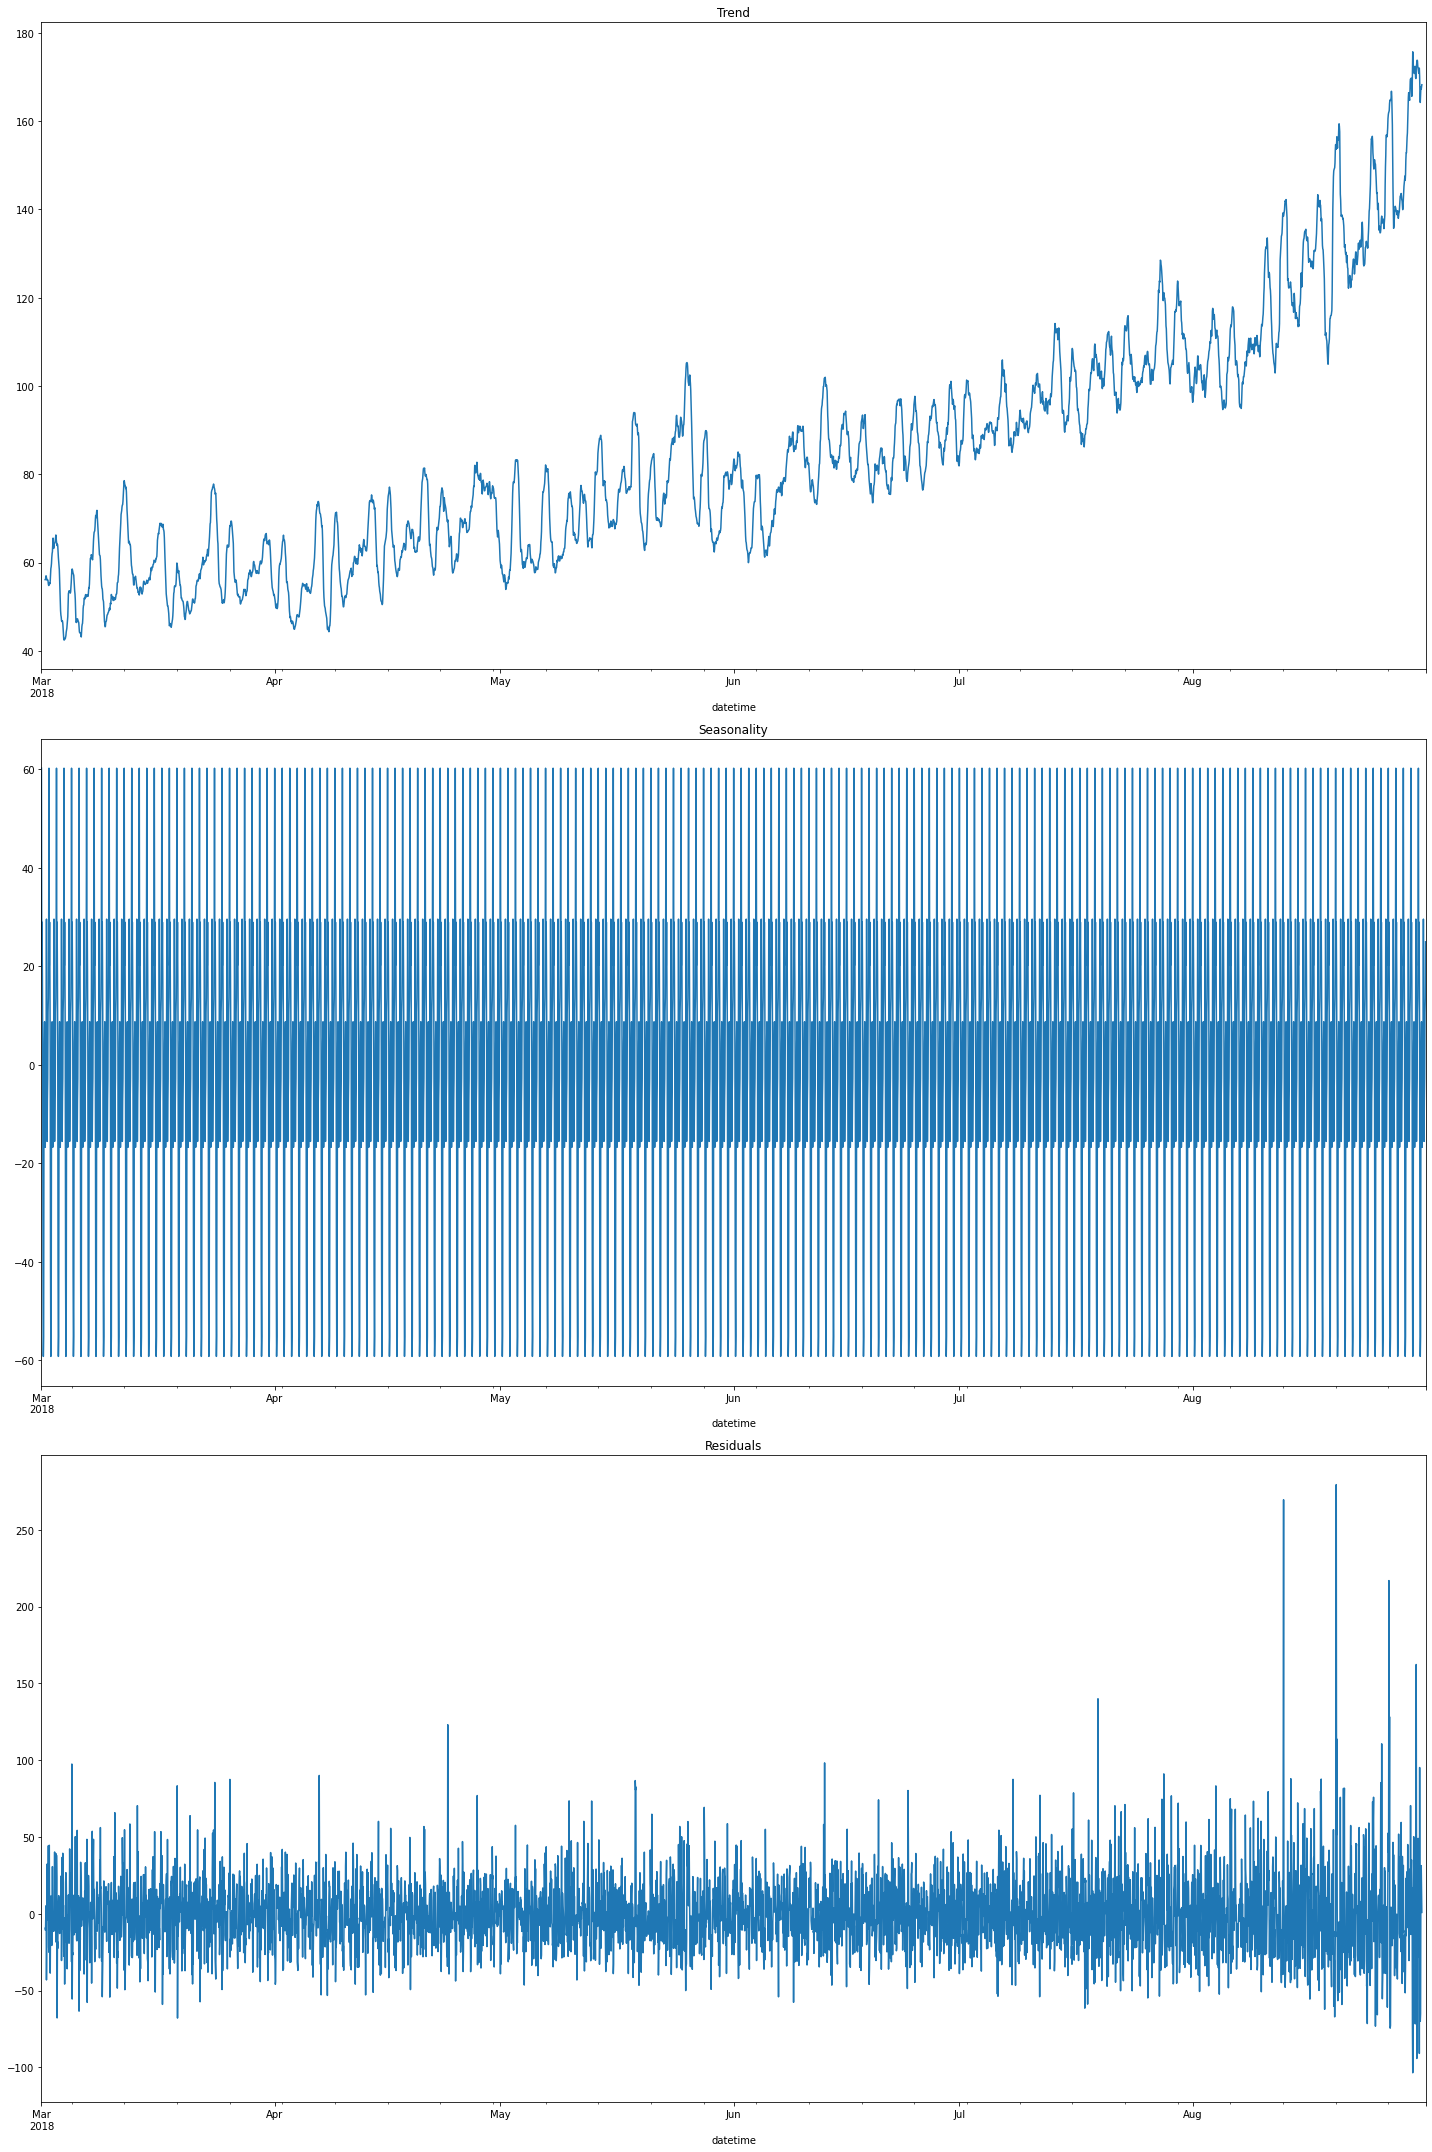

In [7]:
# разложим временной ряд на тренд и сезонную компоненту.
decomposed = seasonal_decompose(data)
plt.figure(figsize=(20, 30))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())   
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())  
plt.title('Residuals')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='datetime'>

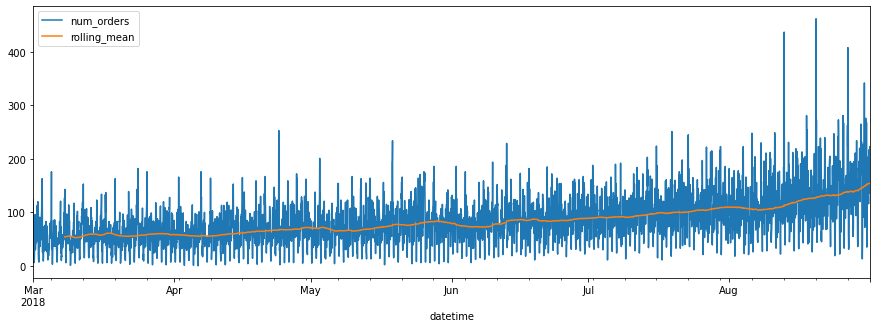

In [8]:
# скользящее среднее с разбивкой на недельные заказы
data['rolling_mean'] = data.rolling(168).mean()
plt.figure(figsize=(15,5))
data.plot(ax=plt.gca())

К концу исследуемого периода, число заказов в аэропортах растет. Посмотрим аналогичные показатели для 1 месяца, недели, дня.

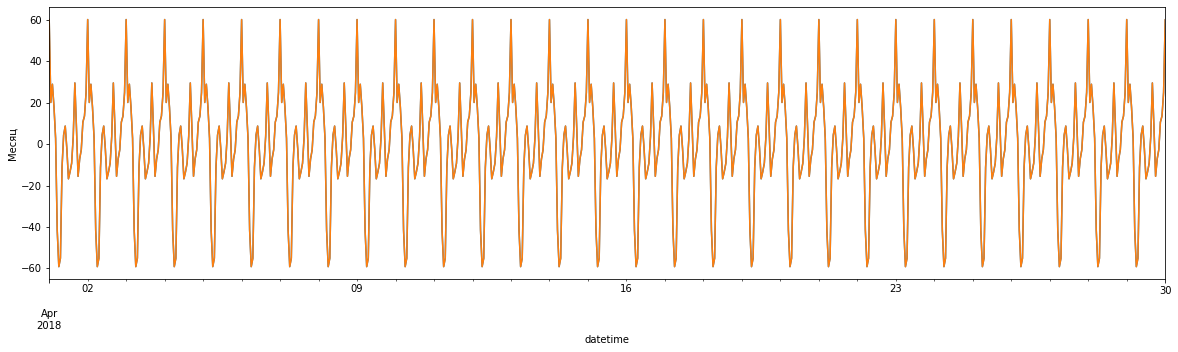

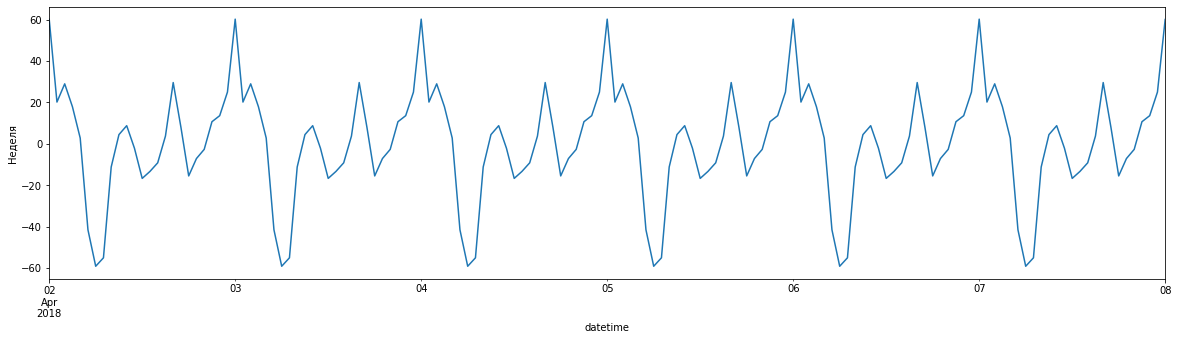

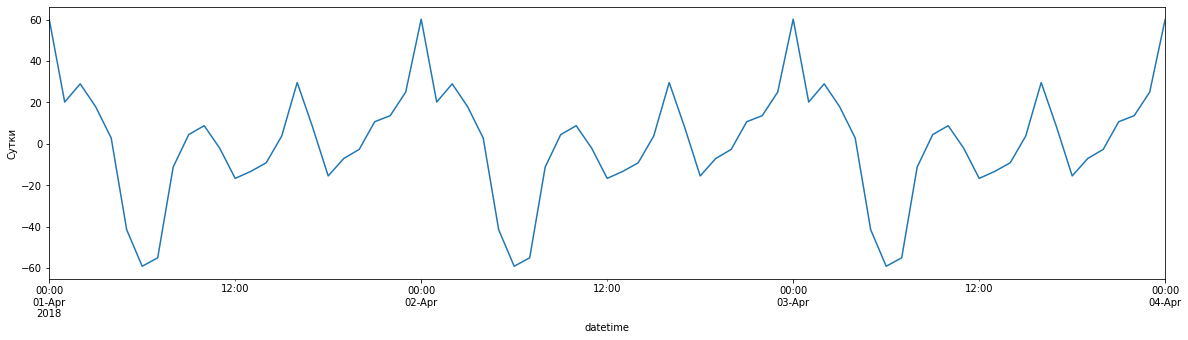

In [9]:
seasonal = decomposed.seasonal
seasonal.plot(figsize=(20,5))

f_day = '2018-04-01'
l_day = '2018-04-30'
seasonal = decomposed.seasonal
seasonal.plot(figsize=(20,5), xlim=(f_day, l_day))
plt.ylabel('Месяц')
plt.show()

f_hour = '2018-04-02'
l_hour = '2018-04-08'
seasonal.plot(figsize=(20,5), xlim=(f_hour, l_hour))
plt.ylabel('Неделя')
plt.show()

f_hour = '2018-04-01'
l_hour = '2018-04-04'
seasonal.plot(figsize=(20,5), xlim=(f_hour, l_hour))
plt.ylabel('Сутки')
plt.show()


Из графиков видно, что колебания происходят в течение суток - к полуночи основной пик заказов, утром - заметный спад. 

### Вывод
Графики составляющих времененного ряда с помощью разложения его на три составляющих иллюстрируют восходящей тренд выраженной внутрисуточной сезонностью, которая повторяется каждый день. Вечером число заказов растет, к полуночи достигает максимальных значений, к утру снижается. 

## Обучение

In [10]:
# Создадим объект RandomState() из модуля numpy.random
state = np.random.RandomState(12345)

Нужно прибавить к таблице четыре новых календарных признака:  месяц, день, день недели и час. Так же добавим новый аргумент rolling_mean_size, который задаст ширину окна.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было написать функцию таким образом, чтобы она возвращала новый датафрейм, а не изменяла глобальную переменную.
</div>

In [12]:
data_c = data.copy()
make_features(data_c, 12, 24)

In [13]:
data_c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4392 non-null   float64
 2   month         4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   hour          4416 non-null   int64  
 6   lag_1         4415 non-null   float64
 7   lag_2         4414 non-null   float64
 8   lag_3         4413 non-null   float64
 9   lag_4         4412 non-null   float64
 10  lag_5         4411 non-null   float64
 11  lag_6         4410 non-null   float64
 12  lag_7         4409 non-null   float64
 13  lag_8         4408 non-null   float64
 14  lag_9         4407 non-null   float64
 15  lag_10        4406 non-null   float64
 16  lag_11        4405 non-null   float64
 17  lag_12        4404 non-null

In [14]:
# Создадим тестовую выборку размером 10% от исходных данных
train, test = train_test_split(data_c, shuffle = False, test_size = 0.1)
train = train.dropna()
print(train.shape)
print(test.shape)

(3950, 18)
(442, 18)


In [15]:
train = train.dropna()

In [16]:
features_train=train.drop (['num_orders'], axis = 1)
target_train=train['num_orders']
features_test=test.drop (['num_orders'], axis = 1)
target_test=test['num_orders']

In [17]:
# Создадим функцию для RMSE
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

In [18]:
# Создадим функцию обучения  моделей, поиска гиперпараметров, значения RMSE
def model_f(model, parameters):

    scorer = make_scorer(rmse_score, greater_is_better=False)
    tscv = TimeSeriesSplit(n_splits=5)
    model_grid = GridSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

Обучим модели: линейную регрессию, дерево решений, случайный лес, CatBoost и LightGBM

**Линейная регрессия**

In [19]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
rmse, best_parameters = model_f (LinearRegression(), parameters)
print('Гиперпараметры линейной регрессии:', best_parameters)
print('RMSE:', abs(rmse.round(2)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=   0.0s
[CV 2/5] END ............fit_intercept=False, nor

In [20]:
all_m = pd.DataFrame ({'model':['LinearRegression'], 'best_parameters_train':[best_parameters], 'RMSE_train':[abs(rmse)]})


**Дерево решений**

In [21]:
parameters = {'max_depth': range(1, 5, 1)}
rmse, best_parameters = model_f (DecisionTreeRegressor(random_state=state), parameters)
print('Гиперпараметры дерева решений:', best_parameters)
print('RMSE', abs(rmse.round(2)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....................................max_depth=1; total time=   0.0s
[CV 2/5] END ....................................max_depth=1; total time=   0.0s
[CV 3/5] END ....................................max_depth=1; total time=   0.0s
[CV 4/5] END ....................................max_depth=1; total time=   0.0s
[CV 5/5] END ....................................max_depth=1; total time=   0.0s
[CV 1/5] END ....................................max_depth=2; total time=   0.0s
[CV 2/5] END ....................................max_depth=2; total time=   0.0s
[CV 3/5] END ....................................max_depth=2; total time=   0.0s
[CV 4/5] END ....................................max_depth=2; total time=   0.0s
[CV 5/5] END ....................................max_depth=2; total time=   0.0s
[CV 1/5] END ....................................max_depth=3; total time=   0.0s
[CV 2/5] END ....................................

In [22]:
all_m = all_m.append({'model':'DecisionTreeRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':abs(rmse)}, ignore_index=True)


**Случайный лес**

In [23]:
parameters = {'n_estimators': range(115, 119, 1), 'max_depth': range(9, 11, 1)}
rmse, best_parameters = model_f(RandomForestRegressor(random_state=state), parameters)
print('Гиперпараметры случайного леса:', best_parameters)
print('RMSE', abs(rmse.round(2)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..................max_depth=9, n_estimators=115; total time=   0.5s
[CV 2/5] END ..................max_depth=9, n_estimators=115; total time=   0.8s
[CV 3/5] END ..................max_depth=9, n_estimators=115; total time=   1.1s
[CV 4/5] END ..................max_depth=9, n_estimators=115; total time=   1.5s
[CV 5/5] END ..................max_depth=9, n_estimators=115; total time=   1.8s
[CV 1/5] END ..................max_depth=9, n_estimators=116; total time=   0.5s
[CV 2/5] END ..................max_depth=9, n_estimators=116; total time=   0.8s
[CV 3/5] END ..................max_depth=9, n_estimators=116; total time=   1.2s
[CV 4/5] END ..................max_depth=9, n_estimators=116; total time=   1.5s
[CV 5/5] END ..................max_depth=9, n_estimators=116; total time=   1.9s
[CV 1/5] END ..................max_depth=9, n_estimators=117; total time=   0.5s
[CV 2/5] END ..................max_depth=9, n_est

In [24]:
all_m = all_m.append({'model':'RandomForestRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':abs(rmse)}, ignore_index=True)


**CatBoostRegressor**

In [25]:
parameters = {'depth': range(3, 5, 1), 'iterations': range(18, 20, 1)}
rmse, best_parameters = model_f(CatBoostRegressor(loss_function="RMSE", learning_rate = 0.5), parameters)
print('Гиперпараметры CatBoostRegressor:', best_parameters)
print('RMSE', abs(rmse.round(2)))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 24.4583856	total: 47ms	remaining: 799ms
1:	learn: 22.3261799	total: 47.8ms	remaining: 382ms
2:	learn: 20.9523403	total: 48.4ms	remaining: 242ms
3:	learn: 20.1784304	total: 49ms	remaining: 171ms
4:	learn: 19.7057875	total: 49.6ms	remaining: 129ms
5:	learn: 19.2411893	total: 50.2ms	remaining: 100ms
6:	learn: 18.7168397	total: 50.7ms	remaining: 79.7ms
7:	learn: 18.4750264	total: 51.3ms	remaining: 64.1ms
8:	learn: 18.1048003	total: 51.9ms	remaining: 51.9ms
9:	learn: 18.0037205	total: 52.5ms	remaining: 42ms
10:	learn: 17.6300979	total: 53.1ms	remaining: 33.8ms
11:	learn: 17.3793678	total: 53.7ms	remaining: 26.9ms
12:	learn: 17.0935760	total: 54.2ms	remaining: 20.9ms
13:	learn: 16.8803574	total: 54.7ms	remaining: 15.6ms
14:	learn: 16.6517136	total: 55.3ms	remaining: 11.1ms
15:	learn: 16.4221114	total: 55.9ms	remaining: 6.99ms
16:	learn: 16.2366007	total: 56.5ms	remaining: 3.33ms
17:	learn: 15.9183068	total: 57.1ms	remainin

In [26]:
all_m = all_m.append({'model':'CatBoostRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':abs(rmse)}, ignore_index=True)


**LGBMRegressor**

In [27]:
parameters = {'n_estimators':range(38, 40, 1)}
rmse, best_parameters = model_f(LGBMRegressor(random_state=state), parameters)
print('Гиперпараметры LGBMRegressor:', best_parameters)
print('RMSE', abs(rmse.round(2)))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ................................n_estimators=38; total time=   0.2s
[CV 2/5] END ................................n_estimators=38; total time=   0.5s
[CV 3/5] END ................................n_estimators=38; total time=   0.4s
[CV 4/5] END ................................n_estimators=38; total time=   0.4s
[CV 5/5] END ................................n_estimators=38; total time=   0.4s
[CV 1/5] END ................................n_estimators=39; total time=   0.3s
[CV 2/5] END ................................n_estimators=39; total time=   0.5s
[CV 3/5] END ................................n_estimators=39; total time=   0.5s
[CV 4/5] END ................................n_estimators=39; total time=   0.3s
[CV 5/5] END ................................n_estimators=39; total time=   0.5s
Гиперпараметры LGBMRegressor: {'n_estimators': 39}
RMSE 24.95


In [28]:
all_m = all_m.append({'model':'LGBMRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':abs(rmse)}, ignore_index=True)
all_m

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",31.355017
1,DecisionTreeRegressor,{'max_depth': 4},30.856376
2,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 118}",25.296309
3,CatBoostRegressor,"{'depth': 3, 'iterations': 18}",26.385173
4,LGBMRegressor,{'n_estimators': 39},24.953890


В результате обучения, лучший RMSE на тренировочной выборке - 24.95 получен на модели LGBMRegressor (n_estimators = 39). На втором месте RandomForestRegressor (max_depth = 10, n_estimators = 118), RMSE на тренировочной выборке - 25.29.

### Вывод
Были обучены 5 моделей, из них, лучше всего себя показала модель LGBMRegressor	(n_estimators = 39). RMSE на тренировочной выборке - 24.95.


## Тестирование

Протестируем модели.

In [29]:
model = LinearRegression(fit_intercept=False, normalize=True)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE', rmse.round(2))

RMSE 50.72


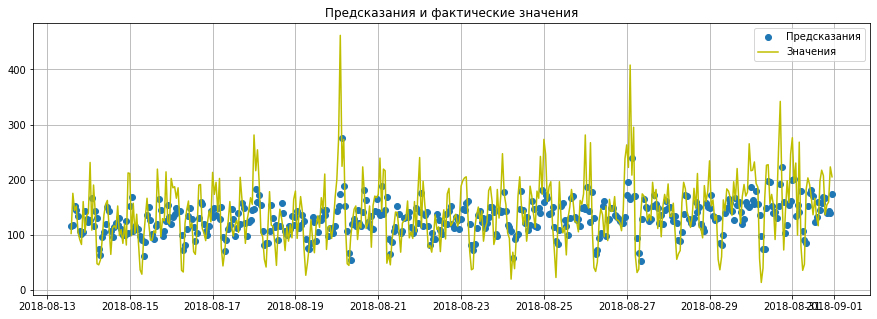

In [30]:
plt.figure(figsize=(15,5))
plt.title('Предсказания и фактические значения')
plt.plot(target_test.index, predictions, 'o', label='Предсказания')
plt.plot(target_test.index, target_test.values, 'y', label='Значения')
plt.legend()
plt.grid(True)

In [31]:
all_m.loc[0, 'RMSE_test'] = rmse

In [32]:
model = DecisionTreeRegressor(random_state=state, max_depth =4)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE', rmse.round(2))

RMSE 60.53


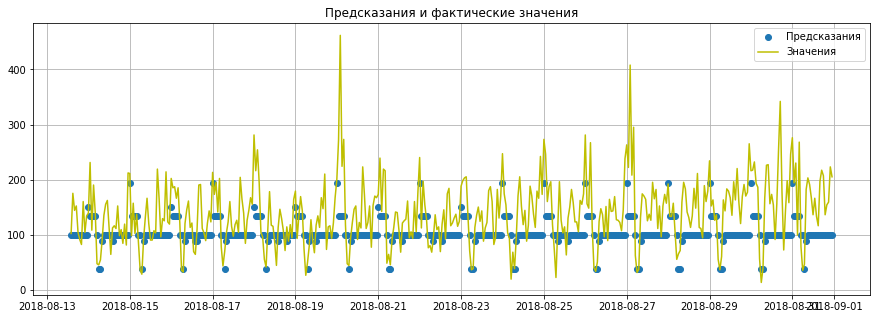

In [33]:
plt.figure(figsize=(15,5))
plt.title('Предсказания и фактические значения')
plt.plot(target_test.index, predictions, 'o', label='Предсказания')
plt.plot(target_test.index, target_test.values, 'y', label='Значения')
plt.legend()
plt.grid(True)

In [34]:
all_m.loc[1, 'RMSE_test'] = rmse

In [35]:
model = RandomForestRegressor(random_state=state, max_depth =10, n_estimators = 118)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE', rmse.round(2))

RMSE 45.03


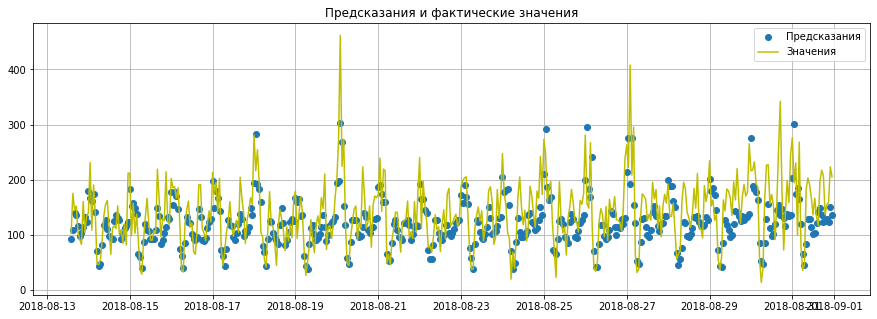

In [36]:
plt.figure(figsize=(15,5))
plt.title('Предсказания и фактические значения')
plt.plot(target_test.index, predictions, 'o', label='Предсказания')
plt.plot(target_test.index, target_test.values, 'y', label='Значения')
plt.legend()
plt.grid(True)

In [37]:
all_m.loc[2, 'RMSE_test'] = rmse

In [38]:
model = CatBoostRegressor(loss_function="RMSE", learning_rate = 0.5, depth=3, iterations=18)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE', rmse.round(2))

0:	learn: 33.9176500	total: 1.46ms	remaining: 24.8ms
1:	learn: 29.7983912	total: 2.77ms	remaining: 22.2ms
2:	learn: 28.1453122	total: 4.04ms	remaining: 20.2ms
3:	learn: 27.1732218	total: 5.15ms	remaining: 18ms
4:	learn: 26.8594972	total: 6.23ms	remaining: 16.2ms
5:	learn: 26.7571111	total: 7.25ms	remaining: 14.5ms
6:	learn: 25.6752198	total: 8.32ms	remaining: 13.1ms
7:	learn: 25.3152927	total: 9.41ms	remaining: 11.8ms
8:	learn: 25.2378487	total: 10.5ms	remaining: 10.5ms
9:	learn: 24.9332861	total: 11.6ms	remaining: 9.29ms
10:	learn: 24.5069611	total: 12.8ms	remaining: 8.14ms
11:	learn: 24.3135812	total: 13.9ms	remaining: 6.95ms
12:	learn: 24.0783831	total: 15ms	remaining: 5.77ms
13:	learn: 24.0211680	total: 16.3ms	remaining: 4.65ms
14:	learn: 23.8688538	total: 17.4ms	remaining: 3.49ms
15:	learn: 23.8369315	total: 18.6ms	remaining: 2.32ms
16:	learn: 23.6109132	total: 19.9ms	remaining: 1.17ms
17:	learn: 23.4807225	total: 21ms	remaining: 0us
RMSE 51.22


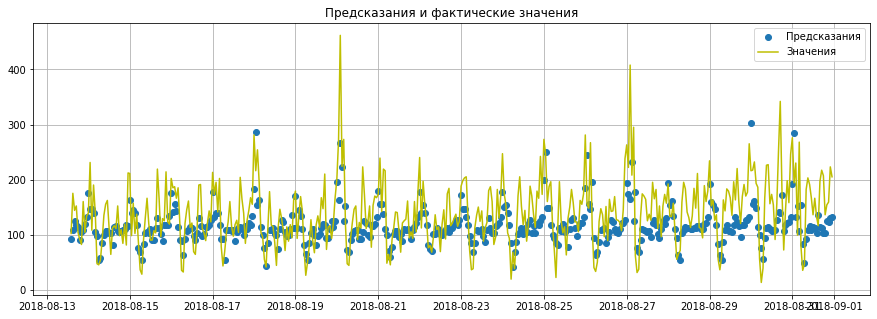

In [39]:
plt.figure(figsize=(15,5))
plt.title('Предсказания и фактические значения')
plt.plot(target_test.index, predictions, 'o', label='Предсказания')
plt.plot(target_test.index, target_test.values, 'y', label='Значения')
plt.legend()
plt.grid(True)

In [40]:
all_m.loc[3, 'RMSE_test'] = rmse

In [41]:
model = LGBMRegressor(random_state=state, n_estimators=39)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE', rmse.round(2))

RMSE 44.55


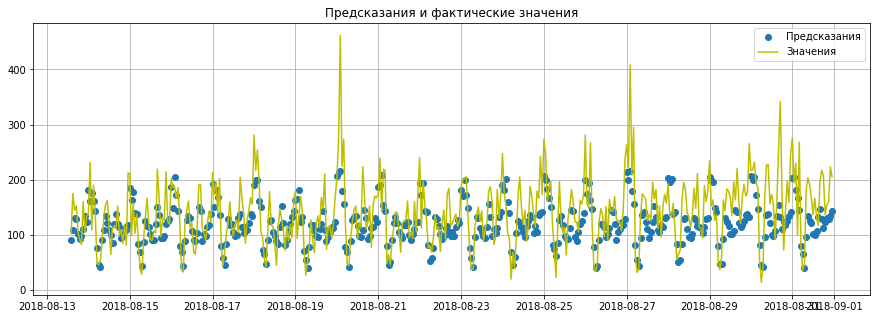

In [42]:
plt.figure(figsize=(15,5))
plt.title('Предсказания и фактические значения')
plt.plot(target_test.index, predictions, 'o', label='Предсказания')
plt.plot(target_test.index, target_test.values, 'y', label='Значения')
plt.legend()
plt.grid(True)

In [43]:
all_m.loc[4, 'RMSE_test'] = rmse
all_m

,model,best_parameters_train,RMSE_train,RMSE_test
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",31.355017,50.722061
1,DecisionTreeRegressor,{'max_depth': 4},30.856376,60.527881
2,RandomForestRegressor,"{'max_depth': 10, 'n_estimators': 118}",25.296309,45.029635
3,CatBoostRegressor,"{'depth': 3, 'iterations': 18}",26.385173,51.220525
4,LGBMRegressor,{'n_estimators': 39},24.953890,44.549559


Лучшие RMSE и на тестовой (44.54), и на тренировочной выборках (24.95), получены у модели LGBMRegressor (n_estimators = 39). На втором месте - RandomForestRegressor	(max_depth = 10, n_estimators = 118. RMSE на тренировочной выборке - 25.29, на тестовой - 45.02. На графика видно, что RandomForestRegressor лучше отражает пиковые значения, а график предсказаний LGBMRegressor сильно сглаживает пиковые значения. 

## Вывод
В ходе проекта проанализированы данные о заказах такси в аэропортах. В ходе анализа выявлено наличие среднесуточных колебаний в числе заказов - пиковый период около полуночи, снижение к 6 утра. За исследуемый период число заказов регулярно растет.
Обучены 5 моделей: линейная регрессия, дерево решений, случайный лес, CatBoost и LightGBM.
И на тестовой и на обучающей выборках лучший RMSE у модели LGBMRegressor (n_estimators = 39). На обучающей - 24.95. На тестовой - 44.54.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48